# Assignment 3 – Topic Modeling and Clustering for Online Social Media Data

*Due: Friday January 12 at 14:00 CET*

In the third assignment of the course Applications of Machine Learning (INFOB3APML), you will learn to use topic modeling and clustering to identify topics in online social media data. The objectives of this assignment are:
- understand and process the text data
- use the clustering algorithm to determine clusters in real-life data
- use the Latent Dirichlet Allocation algorithm to identify discussed topics in real-life text data 
- use the visualization tools to validate the results of unsupervised learning and interpret your findings
- reflect on the difference between two type of unsupervised learning algorithms

In this assignment, you are going to discover the different ‘topics’ from a real social media text dataset. The project is divided into two parts (4 subtasks):

- The first part contains data processing (1.1) and feature extraction (1.2) from the raw text data.
- In the second part, you will implement two methods (2.1), a topic modeling method and a clustering method, to identify topics from the processed data. Then, the evaluation will be done by using visualization tools (2.2). 

Provided files:
- The dataset: data/raw_data.txt
- A tutorial notebook showcases some packages you could use for this assignment (optional): Ass3_tutorial.ipynb
- Some sample visualization codes for interpreting the topic results: viz_example.ipynb

In [1]:
import io

# TODO: import the packages
import spacy
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.cluster import KMeans, DBSCAN

RANDOM_SEED = 42

In [2]:
# load spacy's nl_core_news_sm language model
nlp = spacy.load("nl_core_news_lg")

 ## Dataset:
 The data used in this assignment is Dutch text data. We collected the COVID-19 crisis related messages from online social media (Twitter) from January to November 2021. Then, a subset of raw tweets was randomly sampled. In total, our dataset includes the text data of about 100K messages. **To protect the data privacy, please only use this dataset within the course.**

 ## 0. Before you start the Project: 
 The provided messages in the raw dataset were collected based on 10 different themes that relate to the COVID-19 crisis. Here is a list of all themes:
 -	Lockdown
 -	Face mask
 -	Social distancing
 -	Loneliness
 -	Happiness
 -	Vaccine
 -	Testing
 -  Curfew
 -  Covid entry pass
 -  Work from home

Before starting your project, you need to first filter the messages (all messages are in Dutch) and use the messages belonging to only one theme for the topic identification. 
 
If you have submitted the theme preference, you can skip the following paragraph.

*Please notice that there will be maximum two teams working on a same theme. In this way, we hope that each group will develop their own dataset and come up with interesting results.*

 ## 1.1 Data Processing
 In the first part of the assignment, please first filter the messages and use the messages belonging to your allocated theme for the identification of topics. For that you will need to:
 -	Design your query (e.g. a regular expression or a set of keywords) and filter the related messages for your allocated theme. 
 -	Clean your filtered messages and preprocess them into the right representation. Please refer to the text data pre-processing and representation methods discussed in the lecture. You may use some of the recommended packages for text data preprocessing and representation.

In [3]:
# read the data

def get_data(max = -1, filtered = False):
    rel_path = "../others/data/" + ("raw_data.txt" if not filtered else "filtered_data.txt")
    with io.open(rel_path, "r", encoding="utf-8") as pipe:
        data = []
        cont = 0
        while (cont != max):
            try: 
                raw_text = next(pipe).replace("\\n", "")
            except StopIteration:
                # break if end of file is reached
                pipe.close()
                break

            # remove ill formatted text
            url_pattern = "http(s?)://.+( ?)"
            html_pattern = "&.*;"
            raw_text = re.sub(url_pattern, " ", raw_text)
            raw_text = re.sub(html_pattern, " ", raw_text)
            raw_text = raw_text.replace(".", " ")\
                            .replace("?", " ")\
                            .replace("(", " ")\
                            .replace(")", " ")\
                            .replace(",", " ")\
                            .replace("!", " ")
            
            sentence = nlp(raw_text)
            data.append(sentence)
            cont += 1
    return data

data = get_data(max = -1, filtered= True)

In [4]:
# TODO: filter the related messages
# TOPIC : Loneliness
topic_words = [
    "alleen",         # alone
    "geïsoleerd",     # isolated
    "isolatie",       # isolation
    "kluizenaar",     # hermit
    "eenzaamheid",    # solitude
    "eenzaam",        # lonely
    "virtueel",       # virtual
    "knuffel",        # hug
    "thuis",          # at home
    # "avondklok",      # curfew
]

data_filtered = []
for sentence in data:
    if any(token.lemma_.lower() in topic_words for token in sentence):
        data_filtered.append(sentence)

print(f"filtered {len(data_filtered)} messages related to loneliness")

# store filtered raw data
# with open("filtered_raw_data.txt", "w", encoding="utf-8") as _file:
#     _file.writelines([sentence.text for sentence in data_filtered], )

filtered 10359 messages related to loneliness


In [5]:
# TODO: clean and preprocess the messages
#  - remove URL, mentions, numbers, hashtags, ?emojis?
url_pattern = "^http(s?)://.+"
mention_pattern = "^@.+"
number_pattern = "(\d+,\d+)|(\d+\.\d+)|(\d+%)|(^\d+.*)|(\+\d+)"
emoji_pattern = "[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U00002000-\U000020ff]"

allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']

def match_pattern(pattern, text):
    match = re.match(pattern, text)
    return bool(match)

def generate_hash(sentence):
    text = "".join([token.text for token in sentence])
    return hash(text)


data_processed = {}
sentence_id = 0
for sentence in data_filtered:
    sentence_processed = []

    for token in sentence:

        #  - remove URL, mentions, emojis, 
        if match_pattern(url_pattern, token.text) or \
           match_pattern(mention_pattern, token.text) or \
           match_pattern(emoji_pattern, token.text):
            continue
        
        # - remove numbers, punctuation 
        if token.is_punct or token.is_space or token.is_digit or \
           match_pattern(number_pattern, token.text) :
            continue
        
        #  - Stopping
        if token.is_stop:
            continue

        if token.pos_ not in allowed_postags:
            continue

        sentence_processed.append(token)
    
    # add preprocessed sentence in a way that prevents duplicate messages
    key = generate_hash(sentence_processed)
    if key not in data_processed and len(sentence_processed) >0:
        data_processed[key] = {
            "id" : sentence_id,
            "sentence" : sentence,
            "bow": sentence_processed,
            #  - Stemming & Lemmatization
            "lemmas" : [token.lemma_.lower() for token in sentence_processed]
        }
        sentence_id += 1

print(f"preprocessed {len(data_processed)} unique messages related to loneliness")

<>:5: DeprecationWarning: invalid escape sequence '\d'
<>:5: DeprecationWarning: invalid escape sequence '\d'
/var/folders/52/ltb3n2l53qx00lz973chgvp80000gn/T/ipykernel_28461/2694432919.py:5: DeprecationWarning: invalid escape sequence '\d'
  number_pattern = "(\d+,\d+)|(\d+\.\d+)|(\d+%)|(^\d+.*)|(\+\d+)"


preprocessed 8400 unique messages related to loneliness


In [6]:
# TODO: represent the messages into formats that can be used in clustering or LDA algorithms (you may need different represention for two algorithms)
# generate document term frequency matrix that is going to be used by LDA
documents = [" ".join(sentence["lemmas"]) for sentence in data_processed.values()]

dutch_stopwords = [
    'aan', 'als', 'bij', 'dan', 'dat', 'die', 'dit', 'een', 'en', 'er', 'het',
    'hij', 'hoe', 'hun', 'ik', 'in', 'is', 'je', 'kan', 'maar', 'met', 'mij', 'niet', 'nog',
    'nu', 'of', 'ons', 'ook', 'te', 'tot', 'uit', 'van', 'voor', 'was', 'wat',
    'we', 'wel', 'wij', 'zal', 'ze', 'zei', 'zelf', 'zich', 'zo', 'zij'
]

vectorizer = CountVectorizer(stop_words=dutch_stopwords)
dtf_matrix = vectorizer.fit_transform(documents)
terms = vectorizer.get_feature_names_out()
dtf_df = pd.DataFrame(dtf_matrix.toarray(), columns=terms)



# generate term frequency-inverse document frequency matrix that is going to be used by kmeans
tfid_vectorizer = TfidfVectorizer(stop_words=dutch_stopwords)

tf_df_matrix = tfid_vectorizer.fit_transform(documents) 
tf_df_terms = tfid_vectorizer.get_feature_names_out()
tf_df_df = pd.DataFrame(tf_df_matrix.toarray(), columns=terms)

# spacy vector representation for tokens
for entry in data_processed.values():
    entry["doc_vector"] = np.mean([token.vector for token in entry["bow"]], axis=0) 

word_embeddings_df = pd.DataFrame.from_dict(data_processed, orient='index')
word_embeddings_df = word_embeddings_df.drop(['bow', 'lemmas'], axis="columns")

 ## 1.2 Exploratory Data Analysis
 After preprocessing the data, create at least 2 figures or tables that help you understand the data.

 While exploring the data, you may also think about questions such as:
 - Can you spot any differences between Twitter data and usual text data?
 - Does your exploration reveal some issues that would make it difficult to interpret the topics?
 - Can you improve the data by adding additional preprocessing steps?

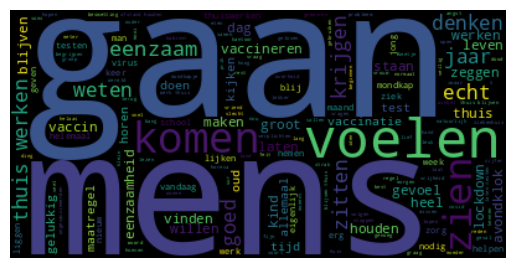

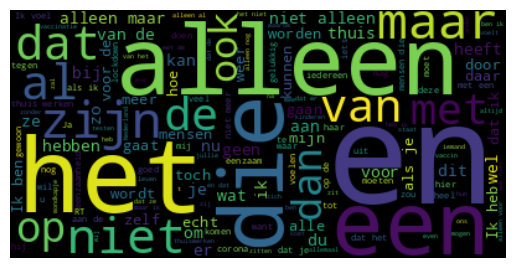

In [7]:
# TODO: plot figure(s)
text_processed = ""
text_original = ""
for key in data_processed:
    entry = data_processed[key]
    text_processed += " " + " ".join(entry["lemmas"])
    text_original += " " + " ".join([token.text for token in entry["sentence"]])

# Create and generate a word cloud image:
processed_wordcloud = WordCloud().generate(text_processed)
original_wordcloud = WordCloud().generate(text_original)

# Display the generated image:
plt.imshow(processed_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.imshow(original_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
word_embeddings_df

,id,sentence,doc_vector
-6523842846516503786,0,"(Gelukkig, en, gezond, 2021, toegewenst, , me...","[0.9748544, -0.39944914, -0.12208892, 0.156692..."
-1882857733719559903,1,"(@thesarge671, @LodewijkA, Ik, heb, mij, , bi...","[0.4796835, -0.5481293, 0.57038134, -0.3480003..."
-7065860958930346942,2,"(@LadyDJane, _, Wat, je, zegt, inderdaad, , I...","[0.56891876, 0.61425936, -0.08865377, 0.251263..."
4417805273615059464,3,"(We, gaan, een, wat, koudere, periode, tegemoe...","[1.3395728, -0.62859803, 0.34129572, -0.308566..."
-2739998281046544128,4,"(ethischer, , beter, voor, die, zielige, aort...","[0.50507003, 0.09264636, 0.08261343, -0.299357..."
...,...,...,...
-4650315264655558111,8395,"(Voila, , Voel, me, een, stuk, beter, , Lekk...","[0.63853854, 0.49458784, -0.40005812, -0.59368..."
-4338334071950128221,8396,"(Jullie, continue, uiting, van, verdriet, , w...","[0.6740434, 0.07708034, -0.179518, 0.30013293,..."
-7207401137447356529,8397,"(Ondernemer, in, het, #, MKB, , controleer, j...","[0.24991402, 0.3688636, 0.75061524, -0.180765,..."
9015650243010348589,8398,"(@CarijnB, @rivm, @GGDGHORNL, @NOS, @RTLnieuws...","[0.8292159, -0.12531625, 0.11857431, -0.408631..."


## 2.1 Topic modelling and clustering
 In the second part of the assignment, you will first:
 -	Implement a Latent Dirichlet Allocation (LDA) algorithm to identify the discussed topics for your theme
 -	Implement a clustering method  to cluster messages into different groups, then represent the topic of each cluster using a bag of words

While implementing the algorithms, you may use the codes from the recommended packages. In the final report, please explain reasons to select the used algorithm/package. 

In [9]:
def get_term_document_matrix(data_mod = None):
    if  not data_mod or data_mod == 'rand':
        np.random.seed(RANDOM_SEED)
        # 100 documents with 35 words each
        return np.random.rand(1000,35)
    if data_mod == 'tmp':
        from sklearn.feature_extraction.text import CountVectorizer
        tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                        lowercase = True,
                                        stop_words = dutch_stopwords,
                                        token_pattern = r'\b[a-zA-Z]{3,}\b',
                                        max_df = 0.5, 
                                        min_df = 10)
        document_term_matrix = tf_vectorizer.fit_transform(data_processed)
        print(document_term_matrix.shape, len(tf_vectorizer.vocabulary_))
        return document_term_matrix, tf_vectorizer
    if data_mod =='processed':
        return dtf_matrix
    
    
def get_word2vector_matrix(data_mod = None):
    if not data_mod or data_mod == 'rand':
        np.random.seed(RANDOM_SEED)
        return np.random.rand(3466,4)
    if data_mod == 'processed':
        raise AttributeError("I don't know processed data yet")
        

def get_document2vector_matrix(data_mod = None):
    if not data_mod or data_mod == 'rand':
        np.random.seed(RANDOM_SEED)
        return np.random.rand(1000,4)
    if data_mod == 'processed':
        liofli = [document_components.tolist() for document_components in word_embeddings_df['doc_vector']]
        return  np.array(liofli)

In [10]:
# TODO: topic modeling using the LDA algorithm

dtm_tf = get_term_document_matrix(data_mod='processed')
tf_vectorizer = vectorizer
lda_tf = LatentDirichletAllocation(n_components=5, random_state=RANDOM_SEED)

doc_topic = lda_tf.fit_transform(dtm_tf)

print("document-term matrix shape:", dtm_tf.shape)
print("document-topic shape: ",doc_topic.shape)
print("example document 1:",doc_topic[1])

tf_lda_tf = LatentDirichletAllocation(n_components=5, random_state=RANDOM_SEED)

tf_doc_topic = tf_lda_tf.fit_transform(tf_df_matrix)

print("tf document-term matrix shape:", tf_df_matrix.shape)
print("tf document-topic shape: ",tf_doc_topic.shape)
print("tf example document 1:",tf_doc_topic[1])

document-term matrix shape: (8400, 15993)
document-topic shape:  (8400, 5)
example document 1: [0.01284463 0.94889639 0.01281139 0.01272719 0.01272039]
tf document-term matrix shape: (8400, 15993)
tf document-topic shape:  (8400, 5)
tf example document 1: [0.04438553 0.82620194 0.04355898 0.04302912 0.04282443]


### Clustering

In [11]:
word_vector_matrx = get_word2vector_matrix(data_mod='rand')
document_vector_matrx = get_document2vector_matrix(data_mod='processed')
word_vector_matrx.shape, document_vector_matrx.shape

((3466, 4), (8400, 300))

In [12]:
# TODO: cluster the messages using a clustering algorithm

kmeans = KMeans(n_clusters=5)

clustrer_labels_kmeans = kmeans.fit_predict(document_vector_matrx)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
#Embedded as the average of words that is composed of
df_kmeans = dtf_df
df_kmeans['cluster'] = clustrer_labels_kmeans

aggregated_clusters_kmeans = df_kmeans.groupby('cluster').sum()
aggregated_clusters_kmeans

,01,04,19,20,21,2uur,55,a29,aaien,aanbeden,...,ïrriteren,ïsoleren,óf,óók,überhaubt,überhaupt,ünheimisch,ķinderbijslag,𝙚𝙚𝙣,𝙚𝙞𝙣𝙙𝙚
cluster,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,1,...,0,0,1,1,1,7,0,1,0,0
1,0,1,11,1,1,0,0,0,0,0,...,0,5,0,5,0,6,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,1,0,1,0,...,1,3,0,2,0,3,1,0,1,1
4,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,2,0,0,0,0


 ## 2.2 Results, evaluation and Interpretation 
 
Finally, you will describe, evaluate and interpret your findings from two methods. 

- In the report, you need to describe and discuss the similarity and difference of results from two methods.
- While evaluating the results, human judgment is very important, so visualization techniques are helpful to evaluate the identified topics in an interpreted manner. 
    
1. For evaluating the topic modelling algorithm, please first use the interactive tool **[pyLDAvis](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=)** to examine the inter-topic separation of your findings. 

2. For interpreting the identified topics / clusters of both algorithms, we provide example code for several visualization techiques. You can use multiple ones to evaluate your results or come up with visualisations on your own. The files contain examples for how to use the visualisation functions.


In [14]:

pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda_tf, dtm_tf, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.067585 -0.021042       1        1  33.925232
2      0.032484  0.063181       2        1  18.585040
3     -0.035644  0.074130       3        1  17.501178
1      0.059170 -0.067618       4        1  17.384324
4     -0.123595 -0.048651       5        1  12.604226, topic_info=             Term         Freq        Total Category  logprob  loglift
15226      werken   852.000000   852.000000  Default  30.0000  30.0000
12844       thuis  1736.000000  1736.000000  Default  29.0000  29.0000
13650  vaccineren   493.000000   493.000000  Default  28.0000  28.0000
12761      testen   289.000000   289.000000  Default  27.0000  27.0000
12748        test   334.000000   334.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
15660  ziekenhuis    32.191355   132.550436   Topic5  -6.0355   0.6559
9660          oud    37.302103   263.840522   Topic5  -5.8882   0.1148
3712          erg    36.840480   265.287082   Topic5  -5.9006   0.0969
4793         goed    40.727264   600.925275   Topic5  -5.8003  -0.6204
12844       thuis    42.912025  1736.821966   Topic5  -5.7481  -1.6295

[440 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
38         3  0.129822        aangaan
38         4  0.778934        aangaan
60         4  0.876973  aangescherpte
116        2  0.770583     aanmerking
116        4  0.128430     aanmerking
...      ...       ...            ...
15825      1  0.367896         zorgen
15825      2  0.408774         zorgen
15825      3  0.091974         zorgen
15825      4  0.040877         zorgen
15825      5  0.081755         zorgen

[868 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

In [15]:
pyLDAvis.lda_model.prepare(tf_lda_tf, tf_df_matrix, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.096287 -0.003381       1        1  41.866699
1     -0.003366  0.006946       2        1  17.278224
2      0.010291  0.034073       3        1  15.649716
3      0.028089 -0.049826       4        1  13.796711
4      0.061273  0.012187       5        1  11.408649, topic_info=             Term       Freq       Total Category  logprob  loglift
2716          dag  61.000000   61.000000  Default  30.0000  30.0000
13604  vaccinatie  32.000000   32.000000  Default  29.0000  29.0000
2734        dalen   5.000000    5.000000  Default  28.0000  28.0000
8070      miljoen  10.000000   10.000000  Default  27.0000  27.0000
12094        stap   7.000000    7.000000  Default  26.0000  26.0000
...           ...        ...         ...      ...      ...      ...
5174         heel   3.381114   57.299095   Topic5  -6.8202  -0.6593
2875       denken   3.411152   62.259649   Topic5  -6.8114  -0.7335
15565      zeggen   3.328951   57.050638   Topic5  -6.8358  -0.6705
15226      werken   3.207356  108.329798   Topic5  -6.8730  -1.3489
3712          erg   3.053083   39.650530   Topic5  -6.9223  -0.3932

[421 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
23         1  0.497580  aandacht
23         2  0.124395  aandacht
23         3  0.373185  aandacht
38         2  0.493733   aangaan
148        3  0.503853   aanslag
...      ...       ...       ...
15912      2  0.472120     zwart
15912      3  0.157373     zwart
15912      4  0.157373     zwart
15912      5  0.157373     zwart
15946      1  0.858234        zó

[753 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [16]:
import sys
sys.path.insert(1, '../others')

from viz import show_topic_wordclouds, show_wordcounts_and_topics, show_topic_distributions

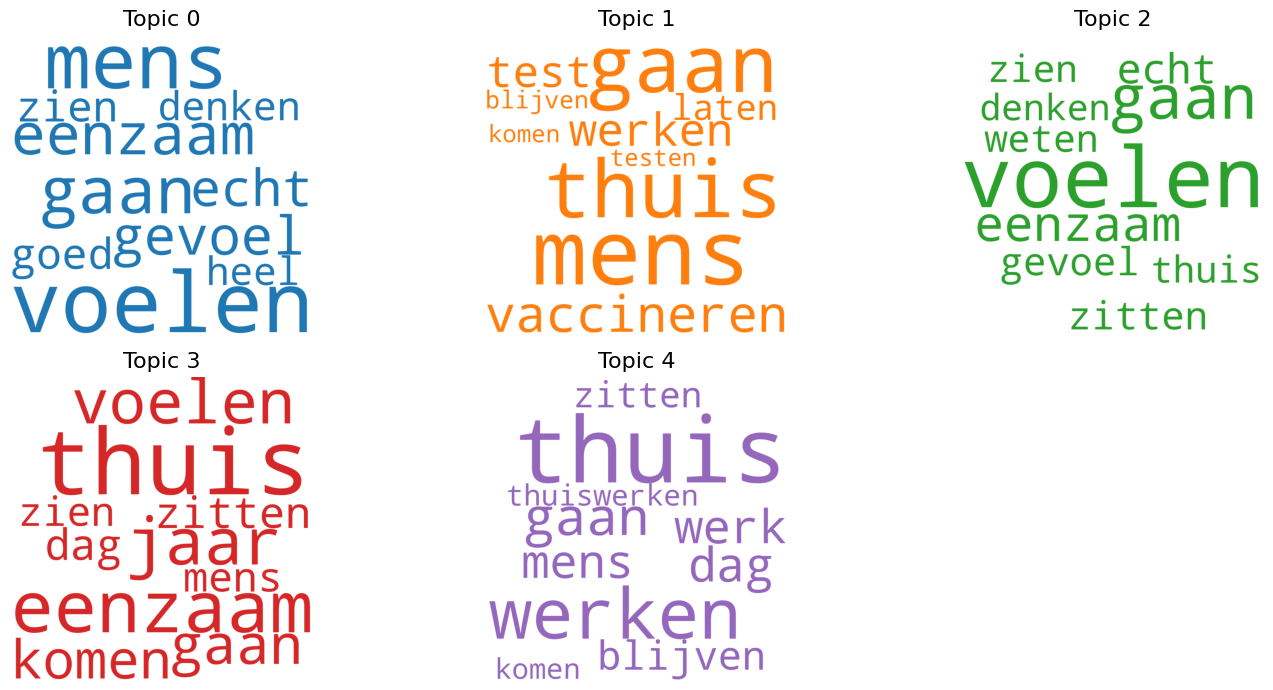

In [17]:
# Show wordclouds 

def get_nested_dictionary(aggregated_cluster, bag_dimension=15):
        top_columns = aggregated_cluster.apply(lambda row: row.nlargest(bag_dimension).index.tolist(), axis=1)
        top_scores = aggregated_cluster.apply(lambda row: row.nlargest(bag_dimension).values.tolist(), axis=1)

        dictionaries = [dict(
                            zip(word, [float(value) for value in top_scores_value])
                            )
                            for word, top_scores_value in zip(top_columns, top_scores)]
        return {i:dictionary for i,dictionary in enumerate(dictionaries)}


def set_show_wordcluds(aggregated_cluster, bag_dimension = 15):

        nested_dictionary = get_nested_dictionary(aggregated_cluster, bag_dimension)

        topic_id = pd.DataFrame(columns=['topic_id'], data=np.arange(0,nested_dictionary.__len__()))

        show_topic_wordclouds(df_dominant_topics=topic_id, topics=nested_dictionary)
        
        

set_show_wordcluds(aggregated_clusters_kmeans)

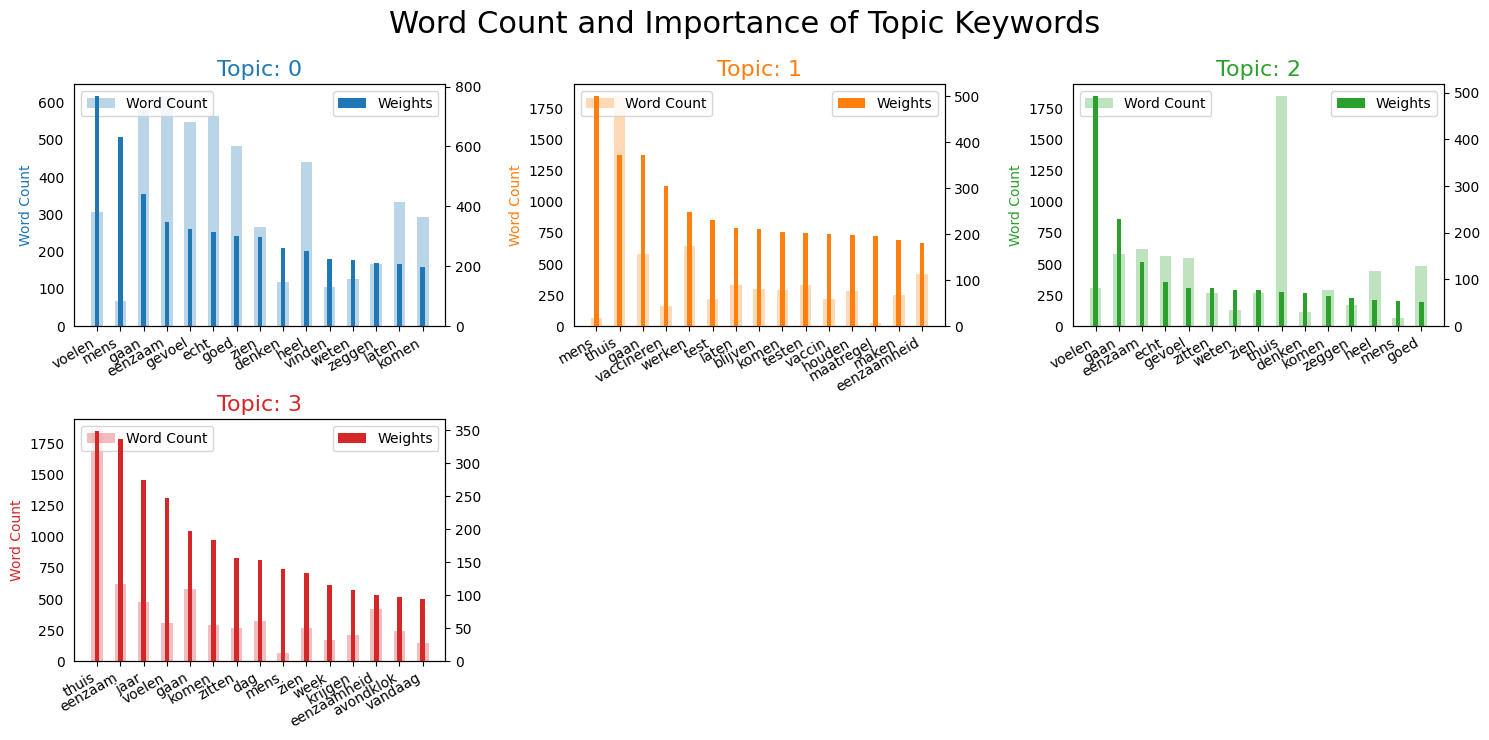

In [18]:
# Show word counts and topics
def set_show_wordcounts(word_embeddings_df, aggregated_clusters):
    word_in_sentences_list = []
    sentences = list(map(lambda token: token.text,word_embeddings_df['sentence'].values.tolist()))
    for sentence in sentences:
        word_in_sentences_list.extend(list(filter(lambda x: x != "" and x != '\n',sentence.split(" "))))

    with warnings.catch_warnings(action="ignore"):
        show_wordcounts_and_topics(get_nested_dictionary(aggregated_clusters), words_in_flat_list=word_in_sentences_list)
        
set_show_wordcounts(word_embeddings_df, aggregated_clusters_kmeans)

,sent_len
topic_id,
0,2061
1,2607
2,739
3,1769
4,1224


,sent_len,topic_id
0,11,4
1,15,1
2,8,2
3,14,1
4,14,0
...,...,...
8395,7,2
8396,15,0
8397,10,3
8398,16,1


ic| strongest_topics: [0, 1, 2, 3, 4]
ic| len(strongest_topics): 5
ic| num_plts_per_row - (num_topics % num_plts_per_row): 1


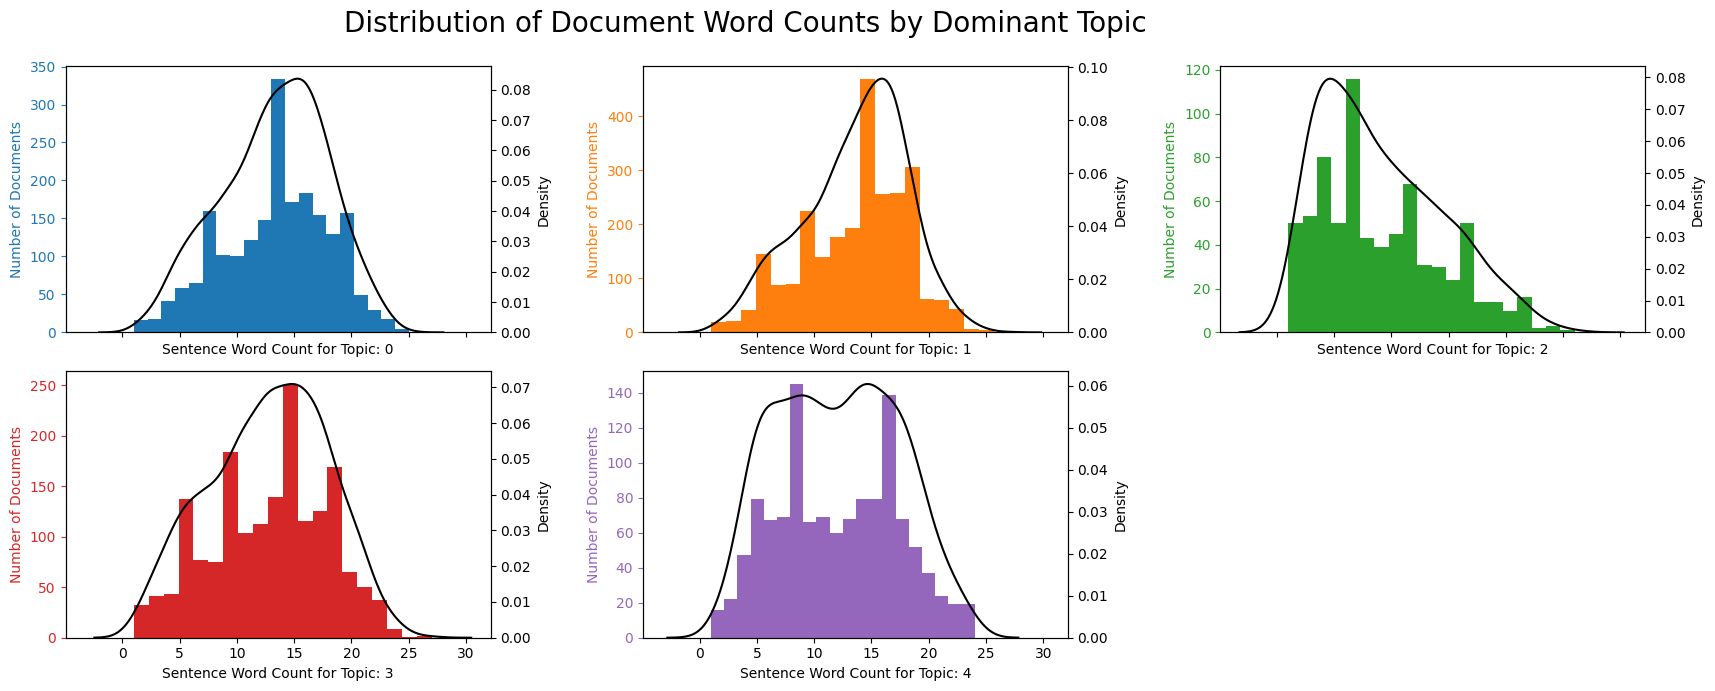

In [19]:
# SHow topic distribution
def set_show_topic_distribution(df, cluster_label):
    length_sentence = pd.DataFrame({'sent_len': df.drop(columns='cluster').sum(axis = 1), 'topic_id': cluster_label})
    display(length_sentence.groupby('topic_id').count())
    display(length_sentence)

    with warnings.catch_warnings(action="ignore"):
        show_topic_distributions2(length_sentence)


def show_topic_distributions2(df_dominant_topics,
                             k=50,
                             num_plts_per_row=3,
                             col_topic_id="topic_id",
                             col_sent_len="sent_len"):
    """This function shows the distribution of topics.

    Args:
        df_dominant_topics (pandas.DataFrame): DataFrame with coloumns containing following information: [topic id, sentence len]. The df needs to be ordered by topic score with the highest at the top. 
        k (int, optional): The top k rows of df_dominat_topics to pic as a basis. Defaults to 50.
        num_plts_per_row (int, optional): Num of plots to be shown per row. Defaults to 3.
        col_* (str, optional): The column name for each important column if you deviate from the default names.
    """
    import seaborn as sns
    import matplotlib.colors as mcolors
    from icecream import ic
    color_map = [color for _, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    strongest_topics = sorted(df_dominant_topics.head(k)[col_topic_id].unique())
    ic(strongest_topics)
    num_topics = ic(len(strongest_topics))
    num_axes_to_delete = ic(num_plts_per_row - (num_topics % num_plts_per_row))
    rows = (num_topics // num_plts_per_row) + 1
    fig, axes = plt.subplots(rows, num_plts_per_row, sharex=True, sharey=False)
    fig.set_size_inches((15, 3.5 * rows))
    for ax in axes[-1, -num_axes_to_delete:].flatten() if len(axes.shape) >1 else axes:
        fig.delaxes(ax)
    fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=20)

    for i, (ax, topic_id) in enumerate(zip(axes.flatten() if len(axes.shape) >1 else axes, strongest_topics)):
        curr_topic_selection = df_dominant_topics[col_topic_id] == topic_id
        most_dominant_topic_sub = df_dominant_topics.loc[curr_topic_selection, :]
        sent_lens = most_dominant_topic_sub[col_sent_len]
        ax.hist(sent_lens, bins=20, color=color_map[i])
        ax.tick_params(axis='y', labelcolor=color_map[i], color=color_map[i])
        sns.kdeplot(sent_lens, color="black", shade=False, ax=ax.twinx())
        ax.set_xlabel(f'Sentence Word Count for Topic: {str(topic_id)}')
        ax.set_ylabel('Number of Documents', color=color_map[i])

    fig.tight_layout()
    fig.subplots_adjust(top=0.9, right=1.1)
    plt.show()
set_show_topic_distribution(df_kmeans, clustrer_labels_kmeans)

# Bonus Tasks 

We would like to challenge you with the following bonus task. For each task that is successfully completed, you may obtain max. 1 extra point. 

1. Implement another clustering algorithm or design your own clustering algorithm. Discuss your findings and explain why this is a better (or worse) clustering algorithm than the above one (the clustering algorithm, not LDA).

2. Can you think of other evaluation methods than the provided visualization techniques? If so, implement one and explain why it is a good evaluation for our task.

## DBSCAN clustering algorithm

In [20]:
# TODO: cluster the messages using a clustering algorithm

dbscan = DBSCAN(metric='cosine', min_samples=6, eps=0.13)

clustrer_labels_dbscan = dbscan.fit_predict(document_vector_matrx)
pd.DataFrame({'cluster':clustrer_labels_dbscan}).value_counts().to_frame()

,count
cluster,
-1,5746
0,2608
1,15
2,11
3,9
5,7
4,4


In [21]:
df_dbscan = dtf_df
df_dbscan['cluster'] = clustrer_labels_dbscan

aggregated_clusters_dbscan = df_dbscan.groupby('cluster').sum().drop(-1)
aggregated_clusters_dbscan

,01,04,19,20,21,2uur,55,a29,aaien,aanbeden,...,ïrriteren,ïsoleren,óf,óók,überhaubt,überhaupt,ünheimisch,ķinderbijslag,𝙚𝙚𝙣,𝙚𝙞𝙣𝙙𝙚
cluster,,,,,,,,,,,,,,,,,,,,,
0,0,0,4,0,0,1,0,0,0,0,...,1,1,0,2,1,5,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


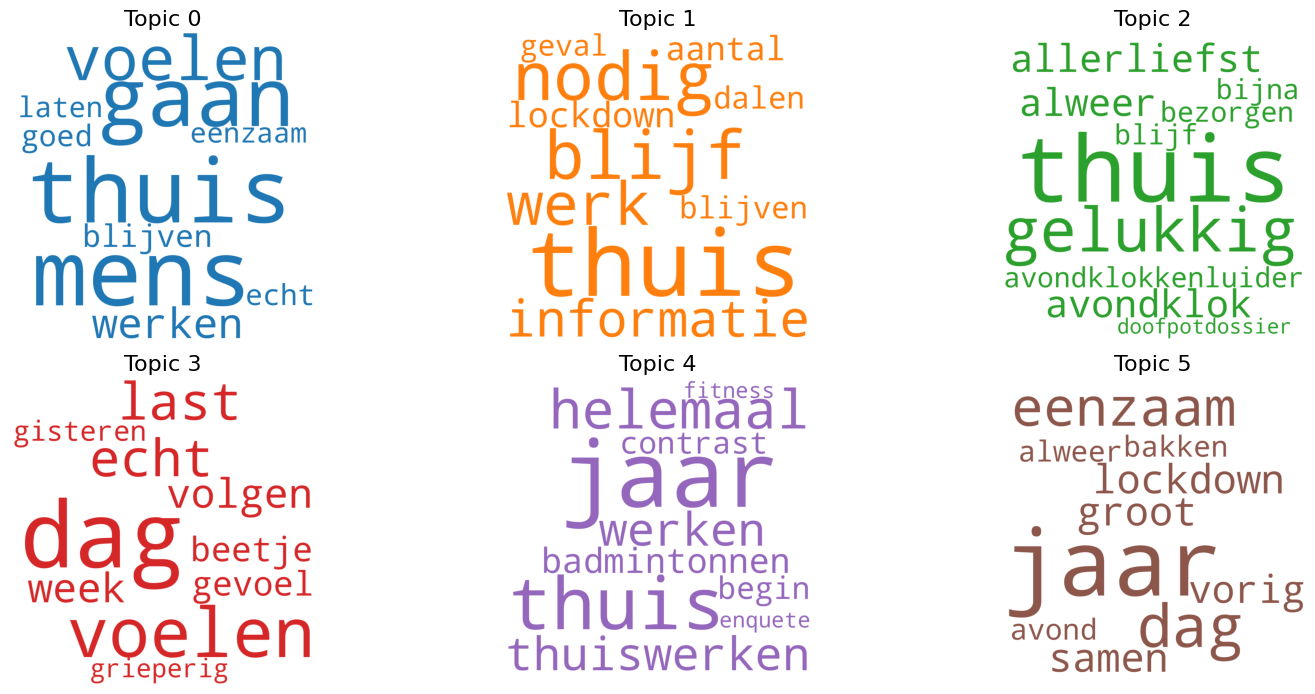

In [22]:
set_show_wordcluds(aggregated_clusters_dbscan)

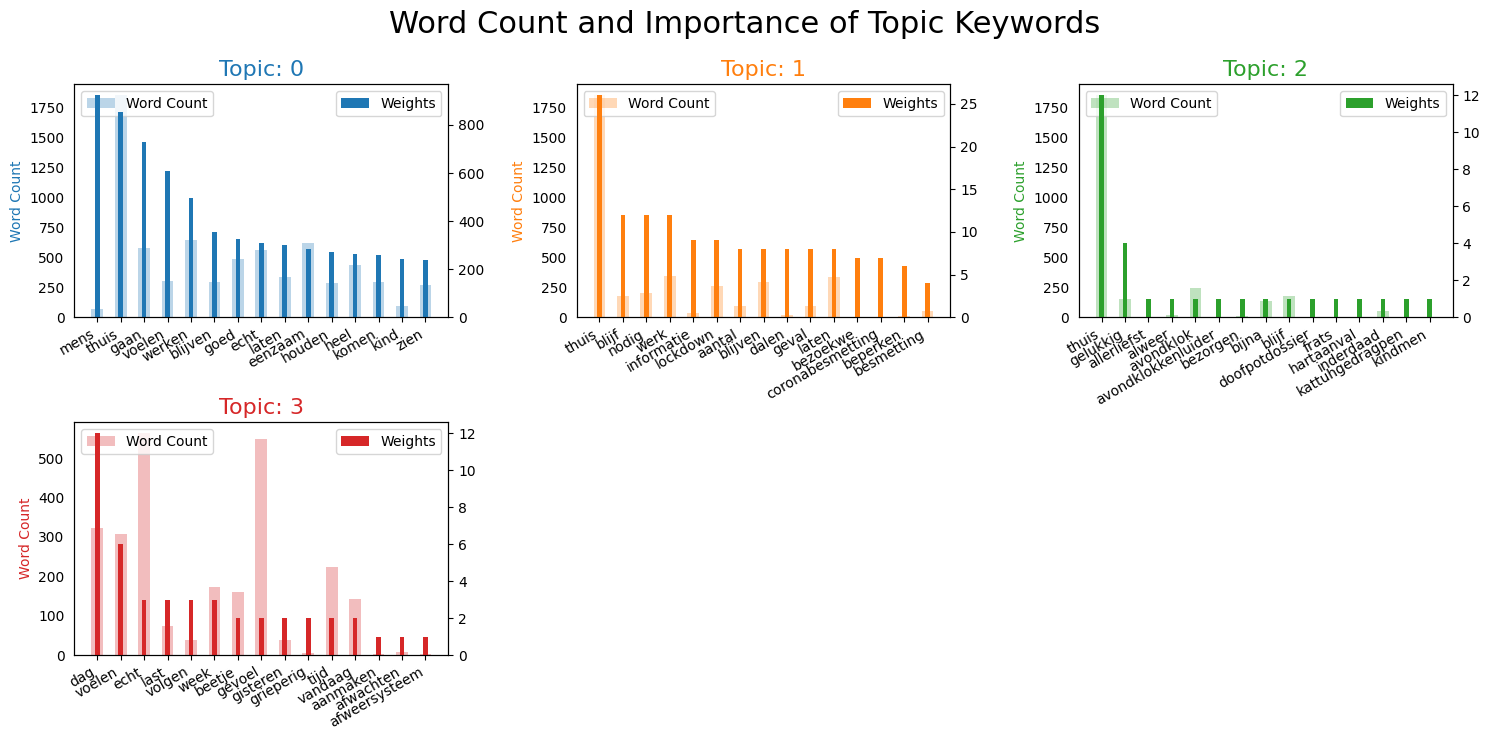

In [23]:
set_show_wordcounts(word_embeddings_df, aggregated_clusters_dbscan)

,sent_len
topic_id,
-1,5746
0,2608
1,15
2,11
3,9
4,4
5,7


,sent_len,topic_id
0,11,-1
1,15,-1
2,8,-1
3,14,-1
4,14,0
...,...,...
8395,7,-1
8396,15,0
8397,10,-1
8398,16,-1


ic| strongest_topics: [-1, 0]
ic| len(strongest_topics): 2
ic| num_plts_per_row - (num_topics % num_plts_per_row): 1


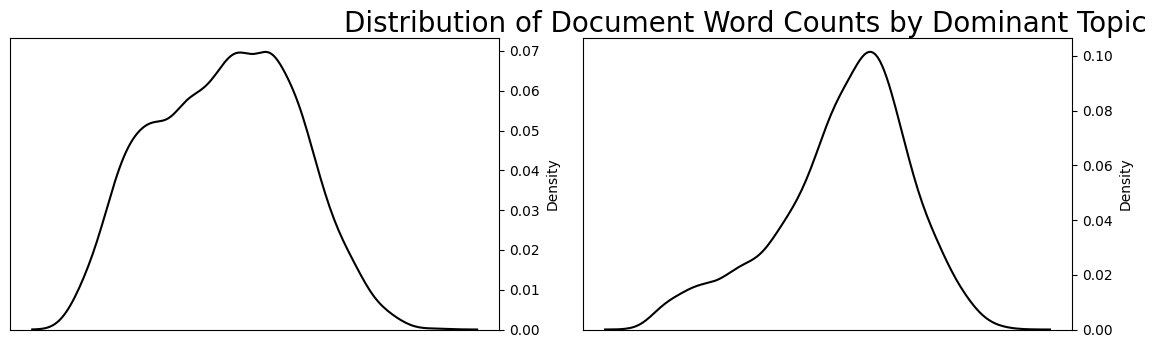

In [24]:
set_show_topic_distribution(df_dbscan, clustrer_labels_dbscan)

## Evaluation Metric

In [25]:
def print_cluster_eval(X, label, clustering_method = ""):
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score 
    print(f"Results for {clustering_method} clustering:")
    print(f"\tSilhouette Score: {silhouette_score(X, label, metric='cosine').round(4)}")
    print(f"\tCalinski Harabasz Score: {calinski_harabasz_score(X, label).round(4)}")
    print(f"\tDavies Boulding Score: {davies_bouldin_score(X, label).round(4)}")

In [26]:
print_cluster_eval(document_vector_matrx, clustrer_labels_kmeans, 'kmeans')

Results for kmeans clustering:
	Silhouette Score: 0.06
	Calinski Harabasz Score: 404.0444
	Davies Boulding Score: 3.2395


In [27]:
print_cluster_eval(document_vector_matrx, clustrer_labels_dbscan, 'dbscan')

Results for dbscan clustering:
	Silhouette Score: -0.1117
	Calinski Harabasz Score: 35.2542
	Davies Boulding Score: 2.9183
